# Kronecker-Factored Laplace Approximation

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Optional, Any
import time
import os

## Example model and training

In [2]:
# Neural Network Models
class SimpleNN(nn.Module):
    """Simple feedforward neural network for MNIST"""
    def __init__(self, input_dim=784, hidden_dims=[1200, 1200], output_dim=10, dropout_rate=0.0):
        super(SimpleNN, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

In [3]:
# Training Function
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, weight_decay=1e-4):
    """Train a neural network model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [4]:
"""Complete training and KFLA evaluation pipeline"""
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data preparation
print("Loading and preparing data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# Split training data for validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model training
print("\nTraining model...")
model = SimpleNN(input_dim=784, hidden_dims=[1200, 1200], output_dim=10)

training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=2,
    lr=1e-3,
    weight_decay=1e-4
)

Loading and preparing data...

Training model...
Starting training...
Epoch: 0, Batch: 0, Loss: 2.3183
Epoch: 0, Batch: 100, Loss: 0.2087
Epoch: 0, Batch: 200, Loss: 0.1312
Epoch: 0, Batch: 300, Loss: 0.1683
Epoch: 0, Batch: 400, Loss: 0.0199
Epoch 1/2:
  Train Loss: 0.1975, Train Acc: 93.91%
  Val Loss: 0.1351, Val Acc: 96.22%
--------------------------------------------------
Epoch: 1, Batch: 0, Loss: 0.0755
Epoch: 1, Batch: 100, Loss: 0.0662
Epoch: 1, Batch: 200, Loss: 0.1300
Epoch: 1, Batch: 300, Loss: 0.1402
Epoch: 1, Batch: 400, Loss: 0.1168
Epoch 2/2:
  Train Loss: 0.0870, Train Acc: 97.30%
  Val Loss: 0.1183, Val Acc: 96.55%
--------------------------------------------------


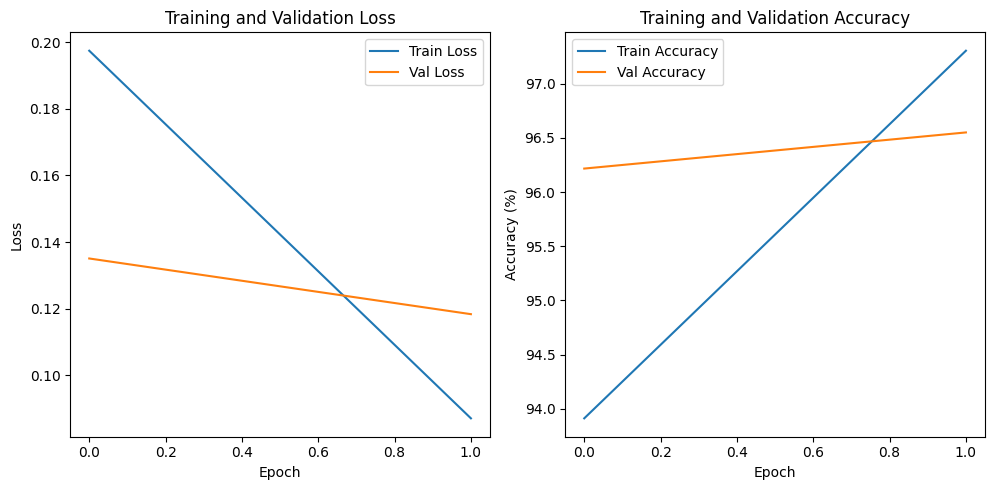

In [5]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['train_losses'], label='Train Loss')
plt.plot(training_history['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(training_history['train_accuracies'], label='Train Accuracy')
plt.plot(training_history['val_accuracies'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

## KFLA class

In [6]:
class LaplaceApproximation:
    """
    A scalable Laplace approximation for neural networks based on Kronecker-factored curvature.
    """
    def __init__(
        self, 
        model: nn.Module, 
        pretrained: bool = True,
        likelihood: str = 'classification',
        verbose: bool = False,
    ):
        self.model = model
        self.is_fitted = False
        self.device = next(model.parameters()).device
        if likelihood in ['classification', 'regression']:
            self.likelihood = likelihood
        else:
            raise ValueError(f"Unsupported likelihood: {self.likelihood}")

        self.pretrained = pretrained
        
        # Storage for Kronecker factors
        self.kronecker_factors = {}
        self.sampling_factors = {}
        self.dataset_size = 1
        
        # Hook handles
        self.hook_handles = []
        
        self.verbose = verbose

    def toggle_verbose(self):
        """
        Turn verbose on or off.
        """
        self.verbose = not self.verbose
        print("Verbose:", "on" if self.verbose else "off")

    def fit(self, 
            train_loader: torch.utils.data.DataLoader,
            val_loader: None = None,
            num_epochs: int = 100,
            lr: float = 1e-3,
            prior_precision: float = 1.0,
            num_samples: int = 1000,
           ) -> Dict[str, List[float]]:
        
        history = {}
        
        if not self.pretrained:
            if self.verbose:
                print('Training model...')
            # Сначала обучаем модель MAP оценке
            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            history['train_loss'] = []
            
            for epoch in range(num_epochs):
                self.model.train()
                train_loss = 0.0
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    output = self.model(batch_X)
                    if self.likelihood == 'classification':
                        loss = F.cross_entropy(output, batch_y)  
                    else:
                        loss = F.mse_loss(output, batch_y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()

                total_loss = train_loss / len(train_loader)
                history['train_loss'].append(total_loss)
                if self.verbose:
                    print(f'Epoch {epoch}: training loss = {total_loss:.4f}')

        self.compute_posterior(train_loader, prior_precision, num_samples)

        return history
        
    def compute_posterior(self, 
                         train_loader: DataLoader,
                         prior_precision: float = 0.0,
                         num_samples: int = 1000) -> None:
        """
        Compute the Kronecker-factored Laplace approximation.
        """
        self.prior_precision = prior_precision
        self.dataset_size = len(train_loader.dataset)
        
        if self.verbose: 
            print("Registering hooks...")
        self._register_hooks()
        
        if self.verbose: 
            print("Estimating Kronecker factors...")
        self._estimate_kronecker_factors(train_loader, num_samples)
        
        if self.verbose: 
            print("Removing hooks...")
        self._remove_hooks()
        
        print("Posterior computation completed!")
        
    def _register_hooks(self) -> None:
        """Register forward hooks to capture activations and pre-activation Hessians."""
        self.activations = {}
        self.pre_activation_hessians = {}
        
        def make_forward_hook(layer_name):
            def forward_hook(module, input, output):
                if isinstance(input, tuple):
                    input = input[0]
                # Store input activations for Q factor
                self.activations[layer_name] = input.detach().clone()
            return forward_hook
        
        # Register hooks for linear layers
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                forward_handle = module.register_forward_hook(make_forward_hook(name))
                self.hook_handles.append(forward_handle)
    
    def _remove_hooks(self) -> None:
        """Remove all registered hooks."""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles.clear()
    
    def _compute_pre_activation_hessian(self, output, target):
        """
        Compute the Hessian with respect to the final layer pre-activations.
        This depends on the likelihood function.
        """
        batch_size = output.shape[0]
        
        if self.likelihood == 'classification':
            # For cross-entropy loss with softmax, the Hessian is:
            # H = diag(p) - pp^T, where p is the softmax probabilities
            probs = F.softmax(output, dim=1)
            eye = torch.eye(probs.size(1), device=self.device).unsqueeze(0)  # (1, C, C)
            probs_outer = torch.einsum('bi,bj->bij', probs, probs)  # (B, C, C)
            hessian = probs_outer - eye  # This is actually -H, but we'll account for sign later
            return -hessian  # Return the negative Hessian of NLL
            
        else: # self.likelihood == 'regression':
            # For MSE loss, the Hessian is identity
            output_dim = output.shape[1]
            hessian = torch.eye(output_dim, device=self.device).unsqueeze(0).repeat(batch_size, 1, 1)
            return hessian
        
    
    def _backward_hessian(self, hessian_final):
        """
        Correct recursive backpropagation of pre-activation Hessian.
        Uses weights of the NEXT layer to compute Hessian for the CURRENT layer.
        """
        hessians = {}
        
        # Get all linear layers in forward order
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))
        
        # Initialize with the final layer Hessian
        if hessian_final.dim() == 3:
            current_hessian = hessian_final.mean(0)  # Average over batch
        else:
            current_hessian = hessian_final
        
        final_layer_name, final_layer = linear_layers[-1]
        hessians[final_layer_name] = current_hessian
        
        # Backpropagate through layers in REVERSE order (from output to input)
        for i in range(len(linear_layers) - 2, -1, -1):  # Start from second-to-last layer
            current_layer_name, current_layer = linear_layers[i]
            next_layer_name, next_layer = linear_layers[i + 1]
            
            # The recursive formula: H_λ = W_{λ+1}^T @ H_{λ+1} @ W_{λ+1} + D_λ
            # For piecewise linear activations (ReLU), D_λ ≈ 0
            W_next = next_layer.weight  # Shape: (out_dim_{λ+1}, in_dim_{λ+1})
            
            # H_current = W_next^T @ H_next @ W_next
            H_current = W_next.T @ current_hessian @ W_next
            
            # Store the Hessian for this layer
            hessians[current_layer_name] = H_current
            
            # Update for next iteration
            current_hessian = H_current
        
        return hessians
    
    def _estimate_kronecker_factors(self, train_loader: DataLoader, num_samples: int) -> None:
        """
        Estimate Kronecker factors using proper Hessian computation.
        """
        self.model.eval()  # We want deterministic behavior for curvature estimation
        
        accumulators = {}
        sample_count = 0
        
        if self.verbose: 
            print(f"Processing up to {num_samples} samples...")
        
        for batch_idx, (data, target) in enumerate(train_loader):
            if sample_count >= num_samples:
                break
                
            data, target = data.to(self.device), target.to(self.device)
            batch_size = data.shape[0]
            
            # Forward pass
            output = self.model(data)
            
            # Compute pre-activation Hessian for the final layer
            H_final = self._compute_pre_activation_hessian(output, target)
            
            # Backpropagate Hessian through all layers
            layer_hessians = self._backward_hessian(H_final)
            
            # Process each layer
            with torch.no_grad():
                for name, module in self.model.named_modules():
                    if isinstance(module, nn.Linear) and name in self.activations and name in layer_hessians:
                        a = self.activations[name]  # input activations (B, in_dim)
                        H = layer_hessians[name]    # pre-activation Hessian (out_dim, out_dim)
                        
                        if name not in accumulators:
                            in_dim = a.shape[1]
                            out_dim = H.shape[0] if H.dim() == 2 else H.shape[1]
                            
                            accumulators[name] = {
                                'Q_sum': torch.zeros(in_dim, in_dim, device=self.device),
                                'H_sum': torch.zeros(out_dim, out_dim, device=self.device),
                                'count': 0,
                                'in_dim': in_dim,
                                'out_dim': out_dim
                            }
                        
                        # Compute Q factor: covariance of input activations
                        batch_Q = torch.einsum('bi,bj->ij', a, a) / batch_size
                        
                        # H factor is already computed from backpropagation
                        # Average if we have multiple samples
                        if H.dim() == 3:  # batch of Hessians
                            batch_H = H.mean(0)
                        else:
                            batch_H = H
                        
                        accumulators[name]['Q_sum'] += batch_Q * batch_size
                        accumulators[name]['H_sum'] += batch_H * batch_size
                        accumulators[name]['count'] += batch_size
                
                sample_count += batch_size
                if sample_count % 1000 == 0 and self.verbose:
                    print(f"Processed {sample_count} samples...")
        
        # Compute final factors with proper regularization
        if self.verbose: 
            print("Computing final Kronecker factors...")
        with torch.no_grad():
            for name, acc in accumulators.items():
                if acc['count'] == 0:
                    continue
                    
                # Expected Kronecker factors (Equation 7 in the paper)
                Q = acc['Q_sum'] / acc['count']  # E[Q_λ]
                H = acc['H_sum'] / acc['count']  # E[H_λ]
                
                # Add prior precision and scale by dataset size (Equation 9)
                N = self.dataset_size
                tau = self.prior_precision
                
                Q_reg = np.sqrt(N) * Q + np.sqrt(tau) * torch.eye(acc['in_dim'], device=self.device)
                H_reg = np.sqrt(N) * H + np.sqrt(tau) * torch.eye(acc['out_dim'], device=self.device)
                
                # Store the precision matrices for sampling
                self.kronecker_factors[name] = {
                    'Q': Q_reg,  # Precision for rows
                    'H': H_reg,  # Precision for columns  
                }
                
                if self.verbose: 
                    print(f"Layer {name}:\nQ shape {Q_reg.shape}, H shape {H_reg.shape}")
                    Q_norm = torch.norm(Q_reg).item()
                    H_norm = torch.norm(H_reg).item()
                    print(f"  Q norm: {Q_norm:.6f}, H norm: {H_norm:.6f}")
                    cond_Q = torch.linalg.cond(Q_reg)
                    cond_H = torch.linalg.cond(H_reg)
                    print(f"cond(Q)={cond_Q:.2e}, cond(H)={cond_H:.2e}")

                # Convert to covariance matrices for sampling
                U = torch.linalg.inv(Q_reg)  # Row covariance
                V = torch.linalg.inv(H_reg)  # Column covariance
                
                # Matrix sqrt for sampling
                L_U = self._matrix_sqrt(U)
                L_V = self._matrix_sqrt(V)

                self.sampling_factors[name] = {
                    'L_U': L_U, 
                    'L_V': L_V, 
                    'weight_shape': (acc['out_dim'], acc['in_dim'])
                }
            
    
    def sample_weights(self, num_samples: int = 1, temperature: float = 1.0) -> List[Dict[str, torch.Tensor]]:
        """
        Sample weight matrices from the matrix normal posterior.
        Returns a list of dictionaries, where each dictionary contains
        the complete set of weights for one sampled model.
        
        Args:
            num_samples: Number of model samples to generate
            
        Returns:
            List of dictionaries, where each dict has layer names as keys
            and sampled weight tensors as values
        """
        samples = []
        
        for i in range(num_samples):
            model_sample = {}
            
            for name, factors in self.sampling_factors.items():
                module = dict(self.model.named_modules())[name]
                M = module.weight.data  # MAP estimate
                
                L_V = factors['L_V']  # Row precision (in_dim, in_dim)
                L_U = factors['L_U']  # Column precision (out_dim, out_dim)
                weight_shape = factors['weight_shape']
                
                # Generate single sample for this layer
                Z = torch.randn(weight_shape, device=self.device)
                W_sample = M + temperature * L_V @ Z @ L_U.T
                
                # Store in the model sample dictionary
                model_sample[f"{name}.weight"] = W_sample.cpu()
            
            # Also include bias terms if they exist
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Linear) and module.bias is not None:
                    # For bias, we can use a simple diagonal approximation
                    # or sample from the appropriate marginal distribution
                    if name in self.kronecker_factors:
                        # The bias is typically part of the same layer's distribution
                        # but for simplicity, we'll use the MAP estimate for bias
                        model_sample[f"{name}.bias"] = module.bias.data.clone()
            
            samples.append(model_sample)
        
        return samples
    
    def _matrix_sqrt(self, A: torch.Tensor) -> torch.Tensor:
        """Compute matrix square root using eigen decomposition."""
        try:
            # Eigen decomposition for symmetric matrices
            L, V = torch.linalg.eigh(A)
            return V @ torch.diag(torch.sqrt(L)) @ V.T
        except:
            # Fallback: use identity
            print("Warning: Matrix sqrt failed, using identity")
            return torch.eye(A.shape[0], device=A.device)
    
    def predictive_distribution(self, 
                              x: torch.Tensor, 
                              weight_samples,
                              return_samples: bool = False):
        """
        Compute predictive distribution using sampled weights.
        """
        # Store original state and create a deep copy to avoid any in-place changes
        original_state_dict = {k: v.clone() for k, v in self.model.state_dict().items()}
        
        predictions = []
        
        for sample_weights in weight_samples:
            # Create a copy of the current model state to modify
            current_state_dict = {k: v.clone() for k, v in original_state_dict.items()}
            
            # Update only the weights that were sampled, keep others at original values
            for name, param in sample_weights.items():
                if name in current_state_dict:
                    current_state_dict[name] = param
                else:
                    print(f"Warning: Parameter {name} not found in model state dict")
            
            # Temporarily load the modified state dict
            self.model.load_state_dict(current_state_dict)
            
            with torch.no_grad():
                output = self.model(x)
                predictions.append(output)
        
        # Always restore the original weights - use the originally saved copy
        self.model.load_state_dict(original_state_dict)
        
        if len(predictions) > 0:
            predictions = torch.stack(predictions)
        else:
            # Fallback - use original model
            with torch.no_grad():
                predictions = self.model(x).unsqueeze(0)
        
        if return_samples:
            return predictions
        else:
            if self.likelihood == 'classification':
                probs = F.softmax(predictions, dim=-1)
                mean_probs = probs.mean(dim=0)
                uncertainty = -(mean_probs * torch.log(mean_probs + 1e-8)).sum(dim=-1)
                return mean_probs, uncertainty
            else:
                mean = predictions.mean(dim=0)
                variance = predictions.var(dim=0)
                return mean, variance

In [7]:
# Let's test with extremely conservative settings
print("Creating KFLA...")

# Make sure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create the Laplace approximation
laplace = LaplaceApproximation(model, likelihood='classification', verbose=True)

# Compute the posterior
print("Computing posterior...")
laplace.compute_posterior(
    train_loader=train_loader,
    prior_precision=1.0,
    num_samples=len(train_dataset)
)

Creating KFLA...
Computing posterior...
Registering hooks...
Estimating Kronecker factors...
Processing up to 60000 samples...
Processed 16000 samples...
Processed 32000 samples...
Processed 48000 samples...
Processed 54000 samples...
Computing final Kronecker factors...
Layer network.0:
Q shape torch.Size([784, 784]), H shape torch.Size([1200, 1200])
  Q norm: 62008.597656, H norm: 10518.829102
cond(Q)=5.81e+04, cond(H)=6.46e+03
Layer network.2:
Q shape torch.Size([1200, 1200]), H shape torch.Size([1200, 1200])
  Q norm: 30549.708984, H norm: 539.554810
cond(Q)=2.45e+04, cond(H)=2.51e+02
Layer network.4:
Q shape torch.Size([1200, 1200]), H shape torch.Size([10, 10])
  Q norm: 94060.820312, H norm: 667.582275
cond(Q)=7.82e+04, cond(H)=1.04e+00
Removing hooks...
Posterior computation completed!


## KFLA evaluation

In [8]:
# Evaluation functions
def evaluate_laplace_model(laplace, test_loader, num_samples=10, temperature=1.0):
    """Evaluate the model with Laplace approximation"""
    laplace.model.eval()
    correct = 0
    total = 0
    uncertainties = []

    print(f"\nSampling {num_samples} weight configurations...")
    weight_samples = laplace.sample_weights(num_samples=num_samples, temperature=temperature)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            mean_probs, uncertainty = laplace.predictive_distribution(
                data, weight_samples
            )
            
            _, predicted = mean_probs.max(1)
            
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            uncertainties.extend(uncertainty.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_uncertainty = np.mean(uncertainties)
    
    return accuracy, avg_uncertainty, uncertainties

def evaluate_standard_model(model, test_loader):
    """Evaluate the standard model"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

In [9]:
# Test standard model first
print("\nEvaluating standard model...")
standard_accuracy = evaluate_standard_model(model, test_loader)
print(f"Standard Model Accuracy: {standard_accuracy:.2f}%")


Evaluating standard model...
Standard Model Accuracy: 96.59%


In [10]:
accuracy, uncertainty, _ = evaluate_laplace_model(
    laplace, test_loader, num_samples=10, temperature=1.0
)
print(f"10 samples, T = 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")


Sampling 10 weight configurations...
10 samples, T = 1.0: Accuracy = 71.69%, Uncertainty = 1.2652


In [11]:
for n_samples in [10, 20, 50, 100, 200]:
    accuracy, uncertainty, _ = evaluate_laplace_model(
        laplace, test_loader, num_samples=n_samples, temperature=1.0
    )
    print(f"{n_samples} samples, T = 1.0: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")


Sampling 10 weight configurations...
10 samples, T = 1.0: Accuracy = 70.78%, Uncertainty = 1.2567

Sampling 20 weight configurations...
20 samples, T = 1.0: Accuracy = 80.13%, Uncertainty = 1.3663

Sampling 50 weight configurations...
50 samples, T = 1.0: Accuracy = 82.13%, Uncertainty = 1.4790

Sampling 100 weight configurations...
100 samples, T = 1.0: Accuracy = 81.26%, Uncertainty = 1.4970

Sampling 200 weight configurations...
200 samples, T = 1.0: Accuracy = 82.94%, Uncertainty = 1.5161


In [12]:
# Test Laplace with very conservative temperatures
print("\nTesting Laplace with different temperatures:")
temperatures = [0.001, 0.01, 0.1, 1, 10]

for temp in temperatures:    
    accuracy, uncertainty, _ = evaluate_laplace_model(
        laplace, test_loader, num_samples=100, temperature=temp
    )
    print(f"Temperature {temp}: Accuracy = {accuracy:.2f}%, Uncertainty = {uncertainty:.4f}")


Testing Laplace with different temperatures:

Sampling 100 weight configurations...
Temperature 0.001: Accuracy = 96.59%, Uncertainty = 0.0940

Sampling 100 weight configurations...
Temperature 0.01: Accuracy = 96.60%, Uncertainty = 0.0940

Sampling 100 weight configurations...
Temperature 0.1: Accuracy = 96.60%, Uncertainty = 0.0949

Sampling 100 weight configurations...
Temperature 1: Accuracy = 82.48%, Uncertainty = 1.4982

Sampling 100 weight configurations...
Temperature 10: Accuracy = 9.78%, Uncertainty = 2.2500


In [13]:
# Let's also look at uncertainty for correct vs incorrect predictions
def analyze_uncertainty_by_accuracy(laplace, test_loader, num_samples=200):
    """Analyze uncertainty for correct vs incorrect predictions"""
    laplace.model.eval()
    correct_uncertainties = []
    incorrect_uncertainties = []

    print("\nSampling weight configurations...")
    weight_samples = laplace.sample_weights(num_samples=num_samples)
    print(f"Sampled {len(weight_samples)} weight configurations")
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get predictive distribution using Laplace approximation
            mean_probs, uncertainty = laplace.predictive_distribution(data, weight_samples)
            
            # Get predictions
            _, predicted = mean_probs.max(1)
            
            # Separate uncertainties for correct and incorrect predictions
            correct_mask = predicted.eq(target)
            incorrect_mask = ~correct_mask
            
            if correct_mask.any():
                correct_uncertainties.extend(uncertainty[correct_mask].cpu().numpy())
            if incorrect_mask.any():
                incorrect_uncertainties.extend(uncertainty[incorrect_mask].cpu().numpy())
    
    return correct_uncertainties, incorrect_uncertainties

In [14]:
correct_unc, incorrect_unc = analyze_uncertainty_by_accuracy(laplace, test_loader)

print(f"\nUncertainty Analysis:")
print(f"Average uncertainty for correct predictions: {np.mean(correct_unc):.4f}")
print(f"Average uncertainty for incorrect predictions: {np.mean(incorrect_unc):.4f}")
print(f"Number of correct predictions: {len(correct_unc)}")
print(f"Number of incorrect predictions: {len(incorrect_unc)}")


Sampling weight configurations...
Sampled 200 weight configurations

Uncertainty Analysis:
Average uncertainty for correct predictions: 1.4530
Average uncertainty for incorrect predictions: 1.8450
Number of correct predictions: 8352
Number of incorrect predictions: 1648


In [15]:
# Example of getting predictions with uncertainty for a single batch
print("\nTesting on a single batch...")
data_iter = iter(test_loader)
test_data, test_target = next(data_iter)
test_data, test_target = test_data.to(device), test_target.to(device)

print("\nSampling weight configurations...")
weight_samples = laplace.sample_weights(num_samples=50)
print(f"Sampled {len(weight_samples)} weight configurations")

mean_probs, uncertainty = laplace.predictive_distribution(test_data, weight_samples)
_, predicted = mean_probs.max(1)

print(f"Predictions for first 10 test samples:")
for i in range(min(10, len(test_data))):
    print(f"  Sample {i+1}: True={test_target[i].item()}, Pred={predicted[i].item()}, "
          f"Uncertainty={uncertainty[i].item():.4f}, "
          f"Correct={predicted[i].eq(test_target[i]).item()}")


Testing on a single batch...

Sampling weight configurations...
Sampled 50 weight configurations
Predictions for first 10 test samples:
  Sample 1: True=7, Pred=7, Uncertainty=1.6039, Correct=True
  Sample 2: True=2, Pred=2, Uncertainty=1.8336, Correct=True
  Sample 3: True=1, Pred=1, Uncertainty=1.4837, Correct=True
  Sample 4: True=0, Pred=0, Uncertainty=1.4466, Correct=True
  Sample 5: True=4, Pred=9, Uncertainty=1.6289, Correct=False
  Sample 6: True=1, Pred=1, Uncertainty=0.9478, Correct=True
  Sample 7: True=4, Pred=9, Uncertainty=1.8827, Correct=False
  Sample 8: True=9, Pred=9, Uncertainty=1.9698, Correct=True
  Sample 9: True=5, Pred=5, Uncertainty=1.9030, Correct=True
  Sample 10: True=9, Pred=9, Uncertainty=1.3490, Correct=True
